# Parkinson’s Disease Classification from 3D MRI Scans

Deep Learning pipeline to classify **Parkinson’s, Prodromal, and Control** subjects from 3D MRI scans.  
Dataset used: [Kaggle Parkinson’s MRI dataset](https://www.kaggle.com/datasets/rishikjha/parkinsons-disease-dat-and-mri-scans)

In [1]:
# Install required libraries
!pip install nibabel torchio monai optuna matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 20.2 MB/s eta 0:00:00


# 1. Imports

In [2]:
import os, sys, shutil, random, math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import optuna
import optuna.visualization as optv

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: cuda


# 2. Dataset Paths

In [3]:

!pip install kaggle

#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Copy kaggle-2.json into ~/.kaggle/ as kaggle.json
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle-2.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

#Download dataset
!kaggle datasets download -d rishikjha/parkinsons-disease-dat-and-mri-scans -p /content

#Unzip
!unzip -q /content/parkinsons-disease-dat-and-mri-scans.zip -d /content/data

#Verify structure
import os
print("Contents of /content/data:", os.listdir("/content/data"))

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/rishikjha/parkinsons-disease-dat-and-mri-scans
License(s): CC-BY-NC-SA-4.0
 97% 928M/959M [00:04<00:00, 141MB/s]
100% 959M/959M [00:04<00:00, 225MB/s]
Contents of /content/data: ['mri_datscan_ppmi']


In [4]:
base_path = "/content/data/mri_datscan_ppmi"

folders = {
    'PD': os.path.join(base_path, 'Mri/PD-30'),
    'Prodromal': os.path.join(base_path, 'Mri/Prodromal-30'),
    'Control': os.path.join(base_path, 'Mri/control-30'),
    'DaT_PD': os.path.join(base_path, 'Datscan/PD-30'),
    'DaT_Prodromal': os.path.join(base_path, 'Datscan/prodromal-30'),
    'DaT_Control': os.path.join(base_path, 'Datscan/control-30'),
    'PDD': os.path.join(base_path, 'datscan b.tech/pdd'),
    'DaT_Control2': os.path.join(base_path, 'datscan b.tech/control'),
}

label_map = {
    'Control': 0, 'DaT_Control': 0, 'DaT_Control2': 0,
    'PD': 1, 'DaT_PD': 1, 'PDD': 1,
    'Prodromal': 2, 'DaT_Prodromal': 2
}

target_shape = (128,128,128)
save_dir = "/content/preprocessed"
os.makedirs(save_dir, exist_ok=True)

# 3. Preprocessing

In [20]:
import os, torch, numpy as np
import torch.nn.functional as F
import nibabel as nib

target_shape = (128,128,128)
X_paths, y_all = [], []
counter, skipped = 0, 0

def load_and_normalize(path):
    try:
        img = nib.load(path).get_fdata().astype(np.float32)
        img = (img - np.mean(img)) / (np.std(img) + 1e-5)
        return img
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

for label, folder in folders.items():  # make sure `folders` and `label_map` are defined
    if not os.path.exists(folder):
        continue
    nii_files = [f for f in os.listdir(folder) if f.endswith(".nii") or f.endswith(".nii.gz")]
    for f in nii_files:
        path = os.path.join(folder, f)
        data = load_and_normalize(path)
        if data is None:
            skipped += 1
            continue

        # skip non-3D volumes
        if data.ndim != 3:
            print(f" Skipping non-3D file {f}, shape={data.shape}")
            skipped += 1
            continue

        t = torch.tensor(data).unsqueeze(0).unsqueeze(0)  # (1,1,D,H,W)
        resized = F.interpolate(t, size=target_shape, mode="trilinear", align_corners=False)
        npy = resized.squeeze().numpy()[np.newaxis,...]   # (1,128,128,128)

        save_path = os.path.join(save_dir, f"sample_{counter}.npy")
        np.save(save_path, npy)
        X_paths.append(save_path)
        y_all.append(label_map[label])
        counter += 1

print(f"\nPreprocessing done. Saved={counter}, Skipped={skipped}")


 Skipping non-3D file PPMI_3378_NM_Reconstructed_DaTSCAN_Br_20200616094635748_1_S550181_I1317557.nii, shape=(109, 91)

Preprocessing done. Saved=687, Skipped=1


##  Visualize raw counts

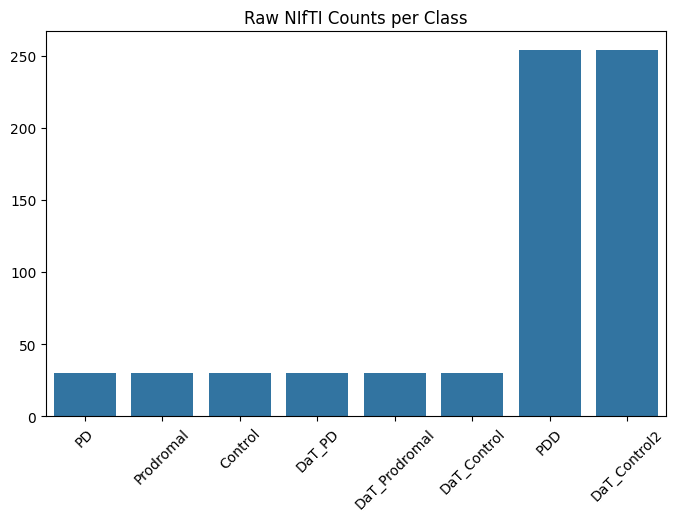

In [21]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45); plt.title("Raw NIfTI Counts per Class")
plt.show()

# 4. Train/Val Split

Train=549, Val=138


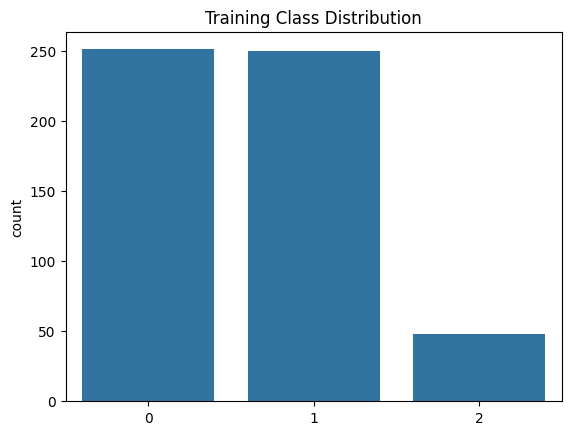

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_paths, y_all, test_size=0.2, stratify=y_all, random_state=42
)
print(f"Train={len(X_train)}, Val={len(X_val)}")

sns.countplot(x=y_train); plt.title("Training Class Distribution"); plt.show()

# 5. Dataset Class with Augmentation

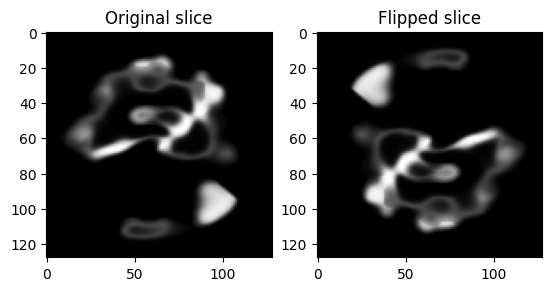

In [23]:
class ParkinsonDataset(Dataset):
    def __init__(self, paths, labels, augment=False):
        self.paths, self.labels, self.augment = paths, labels, augment
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        x = np.load(self.paths[idx])
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.augment: x = self.random_flip(x)
        return x,y
    def random_flip(self, v):
        if random.random()<0.5: v = torch.flip(v,[1])
        return v

# Augmentation example
sample = np.load(X_train[0])[0]
plt.subplot(1,2,1); plt.imshow(sample[64], cmap="gray"); plt.title("Original slice")
plt.subplot(1,2,2); plt.imshow(np.flip(sample[64]), cmap="gray"); plt.title("Flipped slice")
plt.show()

def get_loaders(batch_size):
    return (
        DataLoader(ParkinsonDataset(X_train,y_train,augment=True),batch_size=batch_size,shuffle=True,num_workers=2),
        DataLoader(ParkinsonDataset(X_val,y_val,augment=False),batch_size=batch_size,shuffle=False,num_workers=2)
    )

# 6. Model

In [24]:
class Simple3DCNN(nn.Module):
    def __init__(self, num_filters, dropout):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv3d(1,num_filters,3,1,1),nn.BatchNorm3d(num_filters),nn.ReLU(),nn.MaxPool3d(2),
            nn.Conv3d(num_filters,num_filters*2,3,1,1),nn.BatchNorm3d(num_filters*2),nn.ReLU(),nn.MaxPool3d(2)
        )
        final_dim = target_shape[0]//4
        self.fc = nn.Linear(num_filters*2*final_dim**3,3)
        self.drop = nn.Dropout(dropout)
    def forward(self,x):
        x=self.conv_block(x)
        x=torch.flatten(x,1)
        return self.fc(self.drop(x))

# 7. Optuna Objective Function

In [27]:
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size',[4,8])
    lr = trial.suggest_float('lr',5e-5,5e-4,log=True)
    num_filters = trial.suggest_categorical('num_filters',[16,32,64])
    dropout = trial.suggest_float('dropout',0.2,0.5)

    train_loader,val_loader = get_loaders(batch_size)
    model = Simple3DCNN(num_filters,dropout).to(device)
    opt = optim.Adam(model.parameters(),lr=lr)
    crit = nn.CrossEntropyLoss()

    #  New recommended GradScaler
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type=="cuda"))

    best_acc = 0
    for ep in range(5):  # keep tuning epochs small
        model.train()
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            opt.zero_grad()

#autocast
            with torch.amp.autocast("cuda", dtype=torch.float16, enabled=(device.type=="cuda")):
                out = model(X)
                loss = crit(out,y)

            if device.type=="cuda":
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()

        # validation
        model.eval(); correct=0; total=0
        with torch.no_grad():
            with torch.amp.autocast("cuda", dtype=torch.float16, enabled=(device.type=="cuda")):
                for X,y in val_loader:
                    X,y = X.to(device), y.to(device)
                    out = model(X)
                    pred = out.argmax(1)
                    correct += (pred==y).sum().item()
                    total += y.size(0)
        acc = 100*correct/total

        trial.report(acc, ep)
        if trial.should_prune():
            raise optuna.TrialPruned()

        best_acc = max(best_acc, acc)

    return best_acc


print("\nOptuna tuning...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, gc_after_trial=True)

print("Optuna done. Best params:", study.best_params)


[I 2025-10-03 22:22:43,894] A new study created in memory with name: no-name-b78f3463-4bd1-4fd2-89af-a797cfbc72ed



Optuna tuning...


[I 2025-10-03 22:24:13,644] Trial 0 finished with value: 81.15942028985508 and parameters: {'batch_size': 4, 'lr': 0.00011983378207369746, 'num_filters': 16, 'dropout': 0.4622775972123892}. Best is trial 0 with value: 81.15942028985508.
[I 2025-10-03 22:26:11,725] Trial 1 finished with value: 89.85507246376811 and parameters: {'batch_size': 4, 'lr': 0.00019848132784009193, 'num_filters': 32, 'dropout': 0.3536782800722459}. Best is trial 1 with value: 89.85507246376811.
[I 2025-10-03 22:28:09,824] Trial 2 finished with value: 88.40579710144928 and parameters: {'batch_size': 4, 'lr': 7.146273152608222e-05, 'num_filters': 32, 'dropout': 0.3783191694572206}. Best is trial 1 with value: 89.85507246376811.
[I 2025-10-03 22:32:14,018] Trial 3 finished with value: 89.1304347826087 and parameters: {'batch_size': 8, 'lr': 0.0002901328833654187, 'num_filters': 64, 'dropout': 0.3598046757060324}. Best is trial 1 with value: 89.85507246376811.
[I 2025-10-03 22:33:34,198] Trial 4 finished with value

Optuna done. Best params: {'batch_size': 4, 'lr': 0.00019848132784009193, 'num_filters': 32, 'dropout': 0.3536782800722459}


In [13]:
import numpy as np
shapes = [np.load(p).shape for p in X_paths]
print(set(shapes))


{(1, 128, 128, 128), (1, 128, 128)}


 ## Optuna plots

In [28]:
optv.plot_param_importances(study).show()
optv.plot_slice(study).show()


# 8. Final Training with Best Params

In [29]:
best=study.best_params
train_loader,val_loader=get_loaders(best["batch_size"])
model=Simple3DCNN(best["num_filters"],best["dropout"]).to(device)
opt=optim.Adam(model.parameters(),lr=best["lr"])
crit=nn.CrossEntropyLoss()
scaler=amp.GradScaler()

patience,wait=5,0
best_val_acc=-float("inf")
train_losses,val_losses=[],[]

for epoch in range(15):
    model.train(); running=0
    for X,y in tqdm(train_loader,desc=f"Epoch {epoch+1}"):
        X,y=X.to(device),y.to(device)
        opt.zero_grad()
        with amp.autocast(device_type="cuda",dtype=torch.float16,enabled=device.type=="cuda"):
            out=model(X); loss=crit(out,y)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        running+=loss.item()
    train_losses.append(running/len(train_loader))

    # val
    model.eval(); correct=0; total=0; vloss=0
    with torch.no_grad():
        for X,y in val_loader:
            X,y=X.to(device),y.to(device)
            with amp.autocast(device_type="cuda",dtype=torch.float16,enabled=device.type=="cuda"):
                out=model(X); loss=crit(out,y)
            vloss+=loss.item()
            pred=out.argmax(1); correct+=(pred==y).sum().item(); total+=y.size(0)
    val_acc=100*correct/total
    val_losses.append(vloss/len(val_loader))
    print(f"Epoch {epoch+1}: TrainLoss={train_losses[-1]:.4f}, ValAcc={val_acc:.2f}%")

    if val_acc>best_val_acc+0.001:
        best_val_acc=val_acc; wait=0
        torch.save(model.state_dict(),"/content/best_model.pth")
        print("  Saved best model")
    else:
        wait+=1
    if wait>=patience: print("Early stopping"); break

# Loss curves
plt.plot(train_losses,label="Train"); plt.plot(val_losses,label="Val")
plt.legend(); plt.title("Training vs Validation Loss"); plt.show()

/tmp/ipython-input-1936785737.py:6: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.

Epoch 1:   0%|          | 0/138 [00:00<?, ?it/s]/tmp/ipython-input-1936785737.py:17: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

Epoch 1:   0%|          | 0/138 [00:00<?, ?it/s]


TypeError: autocast.__init__() got an unexpected keyword argument 'device_type'

# 9. Evaluation

In [ ]:
y_true,y_pred=[],[]
model.load_state_dict(torch.load("/content/best_model.pth"))
model.eval()
with torch.no_grad():
    for X,y in val_loader:
        X,y=X.to(device),y.to(device)
        out=model(X)
        preds=out.argmax(1).cpu().numpy()
        y_pred.extend(preds); y_true.extend(y.cpu().numpy())

cm=confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues"); plt.title("Confusion Matrix"); plt.show()
print(classification_report(y_true,y_pred))